# FL4ME: Federated Learning for Medical Diagnostics

This notebook provides comprehensive analysis and visualization of experiments comparing **Centralized** and **Federated Learning** approaches for breast cancer classification.

In medical diagnosis, **recall** is the most important metric because:
- **False negatives are dangerous**: Missing a cancer case can be life-threatening
- **Early detection saves lives**: High recall ensures we catch most true cases
- **Patient safety first**: Better to have false positives than miss actual cancer

This analysis gives special attention to recall performance across all approaches.

## 📋 Notebook Contents:

1. **Performance Metrics Comparison** - Side-by-side comparison of accuracy, precision, **recall**, F1, and AUC-ROC
2. **Recall Analysis** - Dedicated section highlighting recall performance (critical for medical diagnosis)
3. **Training Efficiency** - Analysis of training time vs performance trade-offs
4. **Federated Configuration Trade-offs** - Impact of local epochs vs server rounds on performance and efficiency
5. **Detailed Model Analysis** - ROC curves, precision-recall curves, and classification reports
6. **Summary Statistics** - Key insights and best configurations with focus on recall
7. **Export Results** - Save results for reporting

## 🚀 Quick Start:

1. Run all cells in order
2. Results are fetched from W&B (optimal hyperparameters only)
3. Visualizations and insights are generated automatically
4. Results are exported to `results/` directory

---

## Setup & Data Loading

### Importing Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
import os
from sklearn.metrics import classification_report, roc_curve, auc, precision_recall_curve
from torchvision.transforms import Compose, Normalize, ToTensor
from medmnist import BreastMNIST
from torch.utils.data import DataLoader

# Import your model and utility functions
import sys
sys.path.append('..')
from FL4ME.task import Net, load_data, test

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

### Load Experimental Results

This notebook analyzes runs with **optimal hyperparameters only**:
- **Centralized**: lr=0.001, epochs=30
- **Federated**: lr=0.001, 30 total training steps (various round×epoch configurations)
- **Approaches**: FedAvg, FedProx, DP-FedAvg, DP-FedProx

We filter out hyperparameter search experiments and focus on production-ready configurations.

In [ ]:
# Fetch runs from WandB API with optimal hyperparameters
import wandb

try:
    api = wandb.Api()
    # Fetch runs from FL4ME project
    all_runs = api.runs("louisewiljander-ludwig-maximilianuniversity-of-munich/FL4ME")
    
    # Collect run data with all metrics
    run_data = []
    for run in all_runs:
        training_type = run.config.get('training_type', 'unknown')
        tags = run.tags if hasattr(run, 'tags') else []
        
        # Skip random_search runs
        if 'random_search' in tags:
            continue
        
        # Filter for optimal hyperparameters (lr=0.001 for most, lr=0.01 for FedProx)
        lr = run.config.get('lr', None)
        # Accept lr=0.001 for FedAvg, DP-FedAvg, and Centralized; lr=0.01 for FedProx variants
        is_fedprox = 'optimal-fedprox' in tags or 'optimal-fedprox-dp' in tags
        if is_fedprox:
            if lr != 0.01:  # FedProx optimal lr
                continue
        else:
            if lr != 0.001:  # Other approaches' optimal lr
                continue
            
        data = {
            'run_id': run.id,
            'name': run.name,
            'training_type': training_type,
            'tags': ','.join(tags),
            'state': run.state,
            'lr': lr,
            'final_test_acc': run.summary.get('final_test_acc', None),
            'final_test_loss': run.summary.get('final_test_loss', None),
            'final_precision': run.summary.get('final_precision', None),
            'final_recall': run.summary.get('final_recall', None),
            'final_f1': run.summary.get('final_f1', None),
            'final_auc_roc': run.summary.get('final_auc_roc', None),
            'total_training_time_min': run.summary.get('total_training_time_min', None),
            'created_at': run.created_at,
        }
        
        # Add type-specific metrics
        if training_type == 'centralized':
            epochs = run.config.get('epochs', None)
            if epochs == 30:  # Only optimal configuration
                data['epochs'] = epochs
                data['total_steps'] = epochs
                data['approach'] = 'centralized'
            else:
                continue
        elif training_type == 'federated':
            data['num_rounds'] = run.config.get('num_rounds', None)
            data['local_epochs'] = run.config.get('local_epochs', None)
            data['total_local_epochs'] = run.config.get('total_local_epochs', None)
            data['total_steps'] = run.config.get('total_local_epochs', 0)
            
            # Only include runs with 30 total steps
            if data['total_steps'] != 30:
                continue
            
            # Determine approach from tags (matching actual WandB tags)
            if 'dp-fedavg' in tags:
                data['approach'] = 'dp-fedavg'
            elif 'optimal-fedprox-dp' in tags:
                data['approach'] = 'dp-fedprox'
            elif 'fedavg' in tags:
                data['approach'] = 'fedavg'
            elif 'optimal-fedprox' in tags:
                data['approach'] = 'fedprox'
            else:
                # Fallback to config if tags not available
                aggregation = run.config.get('aggregation', run.config.get('strategy', 'FedAvg'))
                dp_enabled = run.config.get('dp_enabled', False)
                if dp_enabled:
                    data['approach'] = f"dp-{aggregation.lower()}"
                else:
                    data['approach'] = aggregation.lower()
            
            # Store DP settings if applicable
            if 'dp-' in data['approach']:
                data['noise_multiplier'] = run.config.get('noise_multiplier', None)
                data['max_grad_norm'] = run.config.get('max_grad_norm', None)
                data['dp_delta'] = run.config.get('dp_delta', None)
                data['dp_epsilon'] = run.summary.get('dp_epsilon', None)
        
        run_data.append(data)
    
    df_comparison = pd.DataFrame(run_data)
    df_comparison.to_csv('fl4me_optimal_results.csv', index=False)
    print(f"✅ Fetched {len(df_comparison)} runs with optimal hyperparameters from FL4ME")
    
except Exception as e:
    print(f"⚠️ Could not fetch from WandB: {e}")
    print("Trying to load from CSV...")
    try:
        df_comparison = pd.read_csv('fl4me_optimal_results.csv')
        print(f"✅ Loaded {len(df_comparison)} runs from CSV")
    except:
        print("❌ No data available")
        df_comparison = pd.DataFrame()

if not df_comparison.empty:
    # Ensure approach column exists (backward compatibility)
    if 'approach' not in df_comparison.columns:
        df_comparison['approach'] = df_comparison.apply(
            lambda x: 'centralized' if x['training_type'] == 'centralized' else 'fedavg', axis=1
        )
    
    print(f"\n\n📊 Data Summary (Filtered - Optimal Hyperparameters Only, No Random Search):")
    print(f"  Total runs after filtering: {len(df_comparison)}")
    
    print(f"\n  📊 Count per Strategy:")
    print("  " + "="*40)
    strategy_counts = df_comparison['approach'].value_counts().sort_index()
    for strategy, count in strategy_counts.items():
        print(f"  {strategy.upper():20s}: {count}")
    print("  " + "="*40)
    print(f"  {'TOTAL':20s}: {len(df_comparison)}")
    
    display_cols = ['name', 'approach', 'final_test_acc', 'final_recall', 'final_f1', 'total_training_time_min']
    print(f"\n  Top 10 runs by accuracy:")
    display(df_comparison[display_cols].head(10))

wandb: [wandb.Api()] Loaded credentials for https://api.wandb.ai from /Users/louisewiljander/.netrc.


⚠️ Could not fetch from WandB: name 'pd' is not defined
Trying to load from CSV...
❌ No data available


NameError: name 'pd' is not defined

## 1. Performance Metrics Comparison

Comprehensive comparison of all performance metrics across different federated learning approaches.

/var/folders/n4/4l9m_t6d49bg5p46d5j5tmzr0000gn/T/ipykernel_49308/2098911387.py:52: UserWarning: Glyph 9877 (\N{STAFF OF AESCULAPIUS}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/n4/4l9m_t6d49bg5p46d5j5tmzr0000gn/T/ipykernel_49308/2098911387.py:52: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) Arial.
  plt.tight_layout()
/Users/louisewiljander/Library/Python/3.11/lib/python/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 9877 (\N{STAFF OF AESCULAPIUS}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/louisewiljander/Library/Python/3.11/lib/python/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


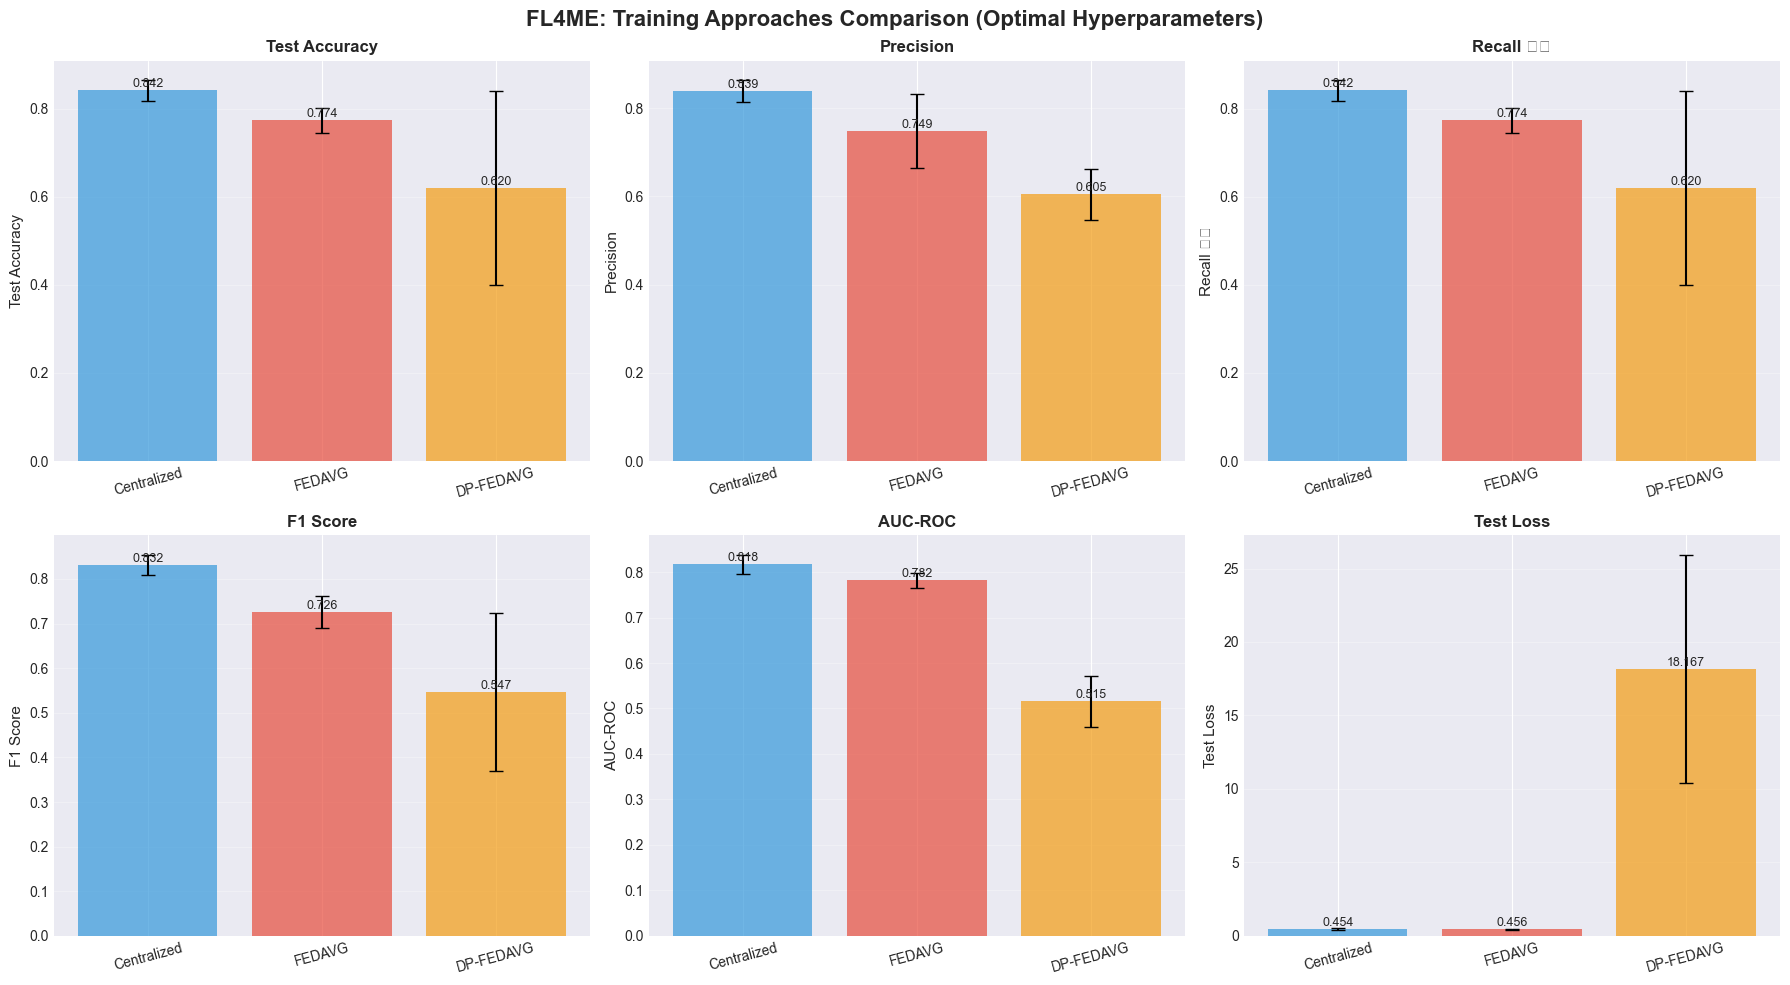


📊 Numerical Comparison (Mean ± Std):
Test Accuracy        | CENTRA: 0.842±0.024 | FEDAVG: 0.774±0.028 | N/A                | DP-FED: 0.620±0.219 | N/A               
Precision            | CENTRA: 0.839±0.026 | FEDAVG: 0.749±0.084 | N/A                | DP-FED: 0.605±0.057 | N/A               
Recall ⚕️            | CENTRA: 0.842±0.024 | FEDAVG: 0.774±0.028 | N/A                | DP-FED: 0.620±0.219 | N/A               
F1 Score             | CENTRA: 0.832±0.023 | FEDAVG: 0.726±0.036 | N/A                | DP-FED: 0.547±0.176 | N/A               
AUC-ROC              | CENTRA: 0.818±0.021 | FEDAVG: 0.782±0.016 | N/A                | DP-FED: 0.515±0.055 | N/A               
Test Loss            | CENTRA: 0.454±0.051 | FEDAVG: 0.456±0.033 | N/A                | DP-FED: 18.167±7.785 | N/A               


In [4]:
if not df_comparison.empty:
    # Filter by approach
    centralized_runs = df_comparison[df_comparison['approach'] == 'centralized']
    fedavg_runs = df_comparison[df_comparison['approach'] == 'fedavg']
    fedprox_runs = df_comparison[df_comparison['approach'] == 'fedprox']
    dp_fedavg_runs = df_comparison[df_comparison['approach'] == 'dp-fedavg']
    dp_fedprox_runs = df_comparison[df_comparison['approach'] == 'dp-fedprox']
    
    # Create comparison bar chart
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    fig.suptitle('FL4ME: Training Approaches Comparison (Optimal Hyperparameters)', fontsize=16, fontweight='bold')
    
    metrics = [
        ('final_test_acc', 'Test Accuracy', axes[0, 0]),
        ('final_precision', 'Precision', axes[0, 1]),
        ('final_recall', 'Recall ⚕️', axes[0, 2]),  # Mark recall as critical
        ('final_f1', 'F1 Score', axes[1, 0]),
        ('final_auc_roc', 'AUC-ROC', axes[1, 1]),
        ('final_test_loss', 'Test Loss', axes[1, 2])
    ]
    
    for metric, label, ax in metrics:
        x_labels = []
        y_vals = []
        err_vals = []
        colors = []
        
        # Collect data for each approach
        for approach, color in [('centralized', '#3498db'), ('fedavg', '#e74c3c'), 
                                 ('fedprox', '#9b59b6'), ('dp-fedavg', '#f39c12'), 
                                 ('dp-fedprox', '#16a085')]:
            approach_data = df_comparison[df_comparison['approach'] == approach]
            if not approach_data.empty and metric in approach_data.columns and approach_data[metric].notna().any():
                x_labels.append(approach.upper() if approach != 'centralized' else 'Centralized')
                y_vals.append(approach_data[metric].mean())
                err_vals.append(approach_data[metric].std())
                colors.append(color)
        
        if len(x_labels) > 0:
            bars = ax.bar(x_labels, y_vals, yerr=err_vals, capsize=5, alpha=0.7, color=colors)
            ax.set_ylabel(label, fontsize=11)
            ax.set_title(label, fontsize=12, fontweight='bold')
            ax.grid(axis='y', alpha=0.3)
            ax.tick_params(axis='x', rotation=15)
            
            # Add value labels on bars
            for bar, val in zip(bars, y_vals):
                height = bar.get_height()
                ax.text(bar.get_x() + bar.get_width()/2., height,
                       f'{val:.3f}', ha='center', va='bottom', fontsize=9)
    
    plt.tight_layout()
    plt.show()
    
    # Print numerical comparison
    print("\n📊 Numerical Comparison (Mean ± Std):")
    print("="*120)
    for metric, label, _ in metrics:
        parts = [f"{label:20s}"]
        
        for approach in ['centralized', 'fedavg', 'fedprox', 'dp-fedavg', 'dp-fedprox']:
            approach_data = df_comparison[df_comparison['approach'] == approach]
            if not approach_data.empty and metric in approach_data.columns and approach_data[metric].notna().any():
                mean_val = approach_data[metric].mean()
                std_val = approach_data[metric].std()
                parts.append(f"{approach.upper()[:6]}: {mean_val:.3f}±{std_val:.3f}")
            else:
                parts.append(f"{'N/A':<18}")
        
        print(" | ".join(parts))
else:
    print("No comparison data available")

## 2. Recall Analysis - Critical for Medical Diagnosis

### ⚕️ Why Recall Matters in Breast Cancer Detection

**Recall (Sensitivity)** is especially important because:
- **False Negatives are Costly**: Missing a cancer case (false negative) can be life-threatening
- **Early Detection Saves Lives**: High recall ensures we catch most true cancer cases
- **Better Safe Than Sorry**: In medical contexts, it's better to have some false positives than to miss actual cases

**Clinical Benchmarks**:
- **≥95%** - Excellent/Gold Standard for cancer screening
- **90-95%** - Good/Clinically Acceptable
- **85-90%** - Borderline Acceptable
- **<85%** - Concerning for cancer detection

**Trade-off**: While we aim for high recall, we also monitor precision to avoid excessive false alarms.

In [ ]:
if not df_comparison.empty:
    # Dedicated Recall Analysis for Medical Diagnosis
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Define colors for different approaches
    style_map = {
        'centralized': {'color': '#3498db', 'label': 'Centralized'},
        'fedavg': {'color': '#e74c3c', 'label': 'FedAvg'},
        'fedprox': {'color': '#9b59b6', 'label': 'FedProx'},
        'dp-fedavg': {'color': '#f39c12', 'label': 'DP-FedAvg'},
        'dp-fedprox': {'color': '#16a085', 'label': 'DP-FedProx'},
    }
    
    # Plot 1: Recall Comparison Bar Chart
    ax = axes[0]
    recall_data = []
    labels = []
    colors_list = []
    
    for approach in ['centralized', 'fedavg', 'fedprox', 'dp-fedavg', 'dp-fedprox']:
        approach_data = df_comparison[df_comparison['approach'] == approach]
        if not approach_data.empty and 'final_recall' in approach_data.columns and approach_data['final_recall'].notna().any():
            mean_val = approach_data['final_recall'].mean()
            std_val = approach_data['final_recall'].std() if len(approach_data) > 1 else 0
            recall_data.append((mean_val, std_val))
            labels.append(style_map[approach]['label'])
            colors_list.append(style_map[approach]['color'])
    
    if recall_data:
        means = [x[0] for x in recall_data]
        stds = [x[1] for x in recall_data]
        
        bars = ax.bar(labels, means, yerr=stds, capsize=5, alpha=0.7, color=colors_list,
                     edgecolor='black', linewidth=1.5)
        
        # Add horizontal lines for clinical benchmarks
        ax.axhline(y=0.95, color='green', linestyle='--', linewidth=2, alpha=0.5, 
                  label='Target: 95% (Gold Standard)')
        ax.axhline(y=0.90, color='orange', linestyle='--', linewidth=1.5, alpha=0.4, 
                  label='Acceptable: 90%')
        ax.axhline(y=0.85, color='red', linestyle='--', linewidth=1.5, alpha=0.4, 
                  label='Minimum: 85%')
        
        ax.set_ylabel('Recall (Sensitivity)', fontsize=13, fontweight='bold')
        ax.set_title('Recall Comparison - Critical for Cancer Detection', fontsize=14, fontweight='bold')
        
        # Set dynamic y-axis limits based on data
        min_recall = max(0.5, min(means) - 0.1)  # Show context even if low
        ax.set_ylim([min_recall, 1.0])
        
        ax.grid(axis='y', alpha=0.3)
        ax.tick_params(axis='x', rotation=15)
        ax.legend(fontsize=9, loc='lower right')
        
        # Add value labels on bars
        for bar, mean, std in zip(bars, means, stds):
            height = bar.get_height()
            if std > 0:
                label_text = f'{mean:.1%}±{std:.1%}'
            else:
                label_text = f'{mean:.1%}'
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   label_text, ha='center', va='bottom', 
                   fontsize=10, fontweight='bold')
    else:
        ax.text(0.5, 0.5, 'No recall data available', 
               ha='center', va='center', transform=ax.transAxes, fontsize=12)
        ax.set_title('Recall Comparison - Critical for Cancer Detection', fontsize=14, fontweight='bold')
    
    # Plot 2: Recall vs Precision Trade-off
    ax = axes[1]
    
    has_data = False
    all_recalls = []
    all_precisions = []
    
    for approach, style in style_map.items():
        approach_data = df_comparison[df_comparison['approach'] == approach]
        if (not approach_data.empty and 
            'final_recall' in approach_data.columns and 
            'final_precision' in approach_data.columns and
            approach_data['final_recall'].notna().any() and 
            approach_data['final_precision'].notna().any()):
            
            recall_vals = approach_data['final_recall'].dropna()
            precision_vals = approach_data['final_precision'].dropna()
            
            # Ensure same length
            min_len = min(len(recall_vals), len(precision_vals))
            recall_vals = recall_vals.iloc[:min_len]
            precision_vals = precision_vals.iloc[:min_len]
            
            if len(recall_vals) > 0:
                has_data = True
                all_recalls.extend(recall_vals.values)
                all_precisions.extend(precision_vals.values)
                
                # Plot each run as a point
                ax.scatter(recall_vals, precision_vals, s=150, alpha=0.7,
                          color=style['color'], label=style['label'],
                          edgecolor='black', linewidth=1.5)
                
                # Add mean as a larger marker
                ax.scatter(recall_vals.mean(), precision_vals.mean(), s=300,
                          color=style['color'], marker='*', edgecolor='black', linewidth=2)
    
    if has_data:
        ax.set_xlabel('Recall (Sensitivity) - True Cancer Detection', fontsize=12, fontweight='bold')
        ax.set_ylabel('Precision - Avoiding False Alarms', fontsize=12, fontweight='bold')
        ax.set_title('Recall-Precision Trade-off Analysis', fontsize=14, fontweight='bold')
        
        # Set dynamic axis limits based on data
        min_recall = max(0, min(all_recalls) - 0.05)
        max_recall = min(1.0, max(all_recalls) + 0.05)
        min_precision = max(0, min(all_precisions) - 0.05)
        max_precision = min(1.0, max(all_precisions) + 0.05)
        
        ax.set_xlim([min_recall, max_recall])
        ax.set_ylim([min_precision, max_precision])
        
        # Add diagonal line showing F1 score
        diag_min = max(min_recall, min_precision)
        diag_max = min(max_recall, max_precision)
        x = np.linspace(diag_min, diag_max, 100)
        ax.plot(x, x, 'k--', alpha=0.3, linewidth=1)
        
        # Add dummy entry for star marker in legend
        ax.scatter([], [], s=300, marker='*', color='gray', edgecolor='black', 
                  linewidth=2, label='Mean (per approach)')
        
        ax.grid(True, alpha=0.3)
        ax.legend(fontsize=10, loc='best')
    else:
        ax.text(0.5, 0.5, 'No precision-recall data available', 
               ha='center', va='center', transform=ax.transAxes, fontsize=12)
        ax.set_title('Recall-Precision Trade-off Analysis', fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed recall analysis
    print("\n⚕️ RECALL ANALYSIS - Critical for Medical Diagnosis\n")
    print("="*80)
    print(f"{'Approach':<15} {'Recall (Mean±Std)':<25} {'Status':<30}")
    print("="*80)
    
    found_any = False
    for approach in ['centralized', 'fedavg', 'fedprox', 'dp-fedavg', 'dp-fedprox']:
        approach_data = df_comparison[df_comparison['approach'] == approach]
        if not approach_data.empty and 'final_recall' in approach_data.columns and approach_data['final_recall'].notna().any():
            found_any = True
            mean_recall = approach_data['final_recall'].mean()
            std_recall = approach_data['final_recall'].std() if len(approach_data) > 1 else 0
            
            # Determine status based on medical benchmarks
            if mean_recall >= 0.95:
                status = "✅ Excellent (≥95%)"
            elif mean_recall >= 0.90:
                status = "✓ Good (90-95%)"
            elif mean_recall >= 0.85:
                status = "⚠️ Acceptable (85-90%)"
            else:
                status = "❌ Needs Improvement (<85%)"
            
            if std_recall > 0:
                print(f"{style_map[approach]['label']:<15} {mean_recall:.4f} ± {std_recall:.4f}        {status}")
            else:
                print(f"{style_map[approach]['label']:<15} {mean_recall:.4f}                 {status}")
    
    if not found_any:
        print("   No recall data available for any approach")
    
    print("="*80)
    print("\n💡 Key Findings:")
    
    # Find best and worst recall
    best_recall_approach = None
    worst_recall_approach = None
    best_recall_val = 0
    worst_recall_val = 1
    
    for approach in ['centralized', 'fedavg', 'fedprox', 'dp-fedavg', 'dp-fedprox']:
        approach_data = df_comparison[df_comparison['approach'] == approach]
        if not approach_data.empty and 'final_recall' in approach_data.columns and approach_data['final_recall'].notna().any():
            mean_recall = approach_data['final_recall'].mean()
            if mean_recall > best_recall_val:
                best_recall_val = mean_recall
                best_recall_approach = style_map[approach]['label']
            if mean_recall < worst_recall_val:
                worst_recall_val = mean_recall
                worst_recall_approach = style_map[approach]['label']
    
    if best_recall_approach:
        print(f"   • Best recall: {best_recall_approach} ({best_recall_val:.1%})")
        print(f"     → Detects {best_recall_val*100:.1f}% of actual cancer cases")
    
    if worst_recall_approach:
        missed_cases = (1 - worst_recall_val) * 100
        print(f"   • Lowest recall: {worst_recall_approach} ({worst_recall_val:.1%})")
        print(f"     → Could miss {missed_cases:.1f}% of actual cancer cases")
    
    # Privacy impact on recall
    fedavg_data = df_comparison[df_comparison['approach'] == 'fedavg']
    dp_fedavg_data = df_comparison[df_comparison['approach'] == 'dp-fedavg']
    if (not fedavg_data.empty and not dp_fedavg_data.empty and 
        'final_recall' in fedavg_data.columns and 'final_recall' in dp_fedavg_data.columns):
        if fedavg_data['final_recall'].notna().any() and dp_fedavg_data['final_recall'].notna().any():
            recall_drop = fedavg_data['final_recall'].mean() - dp_fedavg_data['final_recall'].mean()
            print(f"   • Privacy cost on recall (FedAvg → DP-FedAvg): {recall_drop:.1%}")
    
    fedprox_data = df_comparison[df_comparison['approach'] == 'fedprox']
    dp_fedprox_data = df_comparison[df_comparison['approach'] == 'dp-fedprox']
    if (not fedprox_data.empty and not dp_fedprox_data.empty and 
        'final_recall' in fedprox_data.columns and 'final_recall' in dp_fedprox_data.columns):
        if fedprox_data['final_recall'].notna().any() and dp_fedprox_data['final_recall'].notna().any():
            recall_drop = fedprox_data['final_recall'].mean() - dp_fedprox_data['final_recall'].mean()
            print(f"   • Privacy cost on recall (FedProx → DP-FedProx): {recall_drop:.1%}")
    
    if not best_recall_approach:
        print("   No recall data available for comparison")
    
    print("\n")
else:
    print("No data available for recall analysis")

## 3. Training Efficiency Analysis

Comparing training time and computational efficiency across approaches.

In [ ]:
if not df_comparison.empty:
    fig, axes = plt.subplots(1, 2, figsize=(16, 5))
    
    # Plot 1: Accuracy vs Training Time
    ax = axes[0]
    
    style_map = {
        'centralized': {'color': '#3498db', 'marker': 'o', 'label': 'Centralized'},
        'fedavg': {'color': '#e74c3c', 'marker': 's', 'label': 'FedAvg'},
        'fedprox': {'color': '#9b59b6', 'marker': '^', 'label': 'FedProx'},
        'dp-fedavg': {'color': '#f39c12', 'marker': 'D', 'label': 'DP-FedAvg'},
        'dp-fedprox': {'color': '#16a085', 'marker': 'v', 'label': 'DP-FedProx'},
    }
    
    for approach, style in style_map.items():
        data = df_comparison[df_comparison['approach'] == approach]
        if not data.empty:
            ax.scatter(data['total_training_time_min'], data['final_test_acc'],
                      s=120, alpha=0.7, edgecolor='black', linewidth=1, **style)
    
    ax.set_xlabel('Training Time (minutes)', fontsize=12, fontweight='bold')
    ax.set_ylabel('Test Accuracy', fontsize=12, fontweight='bold')
    ax.set_title('Efficiency: Accuracy vs Training Time', fontsize=14, fontweight='bold')
    ax.legend(fontsize=10, loc='best')
    ax.grid(True, alpha=0.3)
    
    # Plot 2: Training time comparison
    ax = axes[1]
    
    time_data = []
    labels = []
    colors_list = []
    
    for approach in ['centralized', 'fedavg', 'fedprox', 'dp-fedavg', 'dp-fedprox']:
        approach_data = df_comparison[df_comparison['approach'] == approach]
        if not approach_data.empty and 'total_training_time_min' in approach_data.columns and approach_data['total_training_time_min'].notna().any():
            time_data.append((approach_data['total_training_time_min'].mean(),
                             approach_data['total_training_time_min'].std()))
            labels.append(style_map[approach]['label'])
            colors_list.append(style_map[approach]['color'])
    
    if time_data:
        means = [x[0] for x in time_data]
        stds = [x[1] for x in time_data]
        
        bars = ax.bar(labels, means, yerr=stds, capsize=5, alpha=0.7, color=colors_list)
        
        ax.set_ylabel('Training Time (minutes)', fontsize=12, fontweight='bold')
        ax.set_title('Average Training Time Comparison', fontsize=14, fontweight='bold')
        ax.grid(axis='y', alpha=0.3)
        ax.tick_params(axis='x', rotation=15)
        
        for bar, mean, std in zip(bars, means, stds):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{mean:.2f}±{std:.2f}', ha='center', va='bottom', fontsize=9)
    
    plt.tight_layout()
    plt.show()
    
    print("\n⏱️ Training Efficiency:")
    for approach in ['centralized', 'fedavg', 'fedprox', 'dp-fedavg', 'dp-fedprox']:
        approach_data = df_comparison[df_comparison['approach'] == approach]
        if not approach_data.empty and 'total_training_time_min' in approach_data.columns and approach_data['total_training_time_min'].notna().any():
            mean_time = approach_data['total_training_time_min'].mean()
            std_time = approach_data['total_training_time_min'].std()
            print(f"  {style_map[approach]['label']}: {mean_time:.2f} ± {std_time:.2f} minutes")
else:
    print("No timing data available")

## 4. Federated Configuration Analysis

Comparing different federated learning configurations: rounds vs local epochs trade-offs.

In [ ]:
if not df_comparison.empty:
    federated_only = df_comparison[df_comparison['training_type'] == 'federated'].copy()
    
    if not federated_only.empty and len(federated_only) > 1:
        fig, axes = plt.subplots(1, 2, figsize=(16, 6))
        fig.suptitle('FL4ME: Federated Configuration Analysis', fontsize=16, fontweight='bold')
        
        # Plot 1: Configuration comparison by approach
        ax = axes[0]
        
        # Group by configuration
        config_summary = federated_only.groupby(['num_rounds', 'local_epochs', 'approach']).agg({
            'final_test_acc': 'mean',
            'final_recall': 'mean'
        }).reset_index()
        
        # Plot each approach
        colors = {'fedavg': '#e74c3c', 'fedprox': '#9b59b6', 
                  'dp-fedavg': '#f39c12', 'dp-fedprox': '#16a085'}
        
        for approach in config_summary['approach'].unique():
            data = config_summary[config_summary['approach'] == approach]
            config_labels = [f"{int(r)}×{int(le)}" for r, le in zip(data['num_rounds'], data['local_epochs'])]
            ax.plot(range(len(data)), data['final_test_acc'], marker='o', linewidth=2,
                   label=approach.upper(), color=colors.get(approach, 'gray'), markersize=8)
        
        ax.set_xlabel('Configuration', fontsize=12, fontweight='bold')
        ax.set_ylabel('Test Accuracy', fontsize=12, fontweight='bold')
        ax.set_title('Accuracy by Configuration', fontsize=13, fontweight='bold')
        ax.legend(fontsize=10)
        ax.grid(True, alpha=0.3)
        
        # Plot 2: Recall by configuration
        ax = axes[1]
        
        for approach in config_summary['approach'].unique():
            data = config_summary[config_summary['approach'] == approach]
            ax.plot(range(len(data)), data['final_recall'], marker='s', linewidth=2,
                   label=approach.upper(), color=colors.get(approach, 'gray'), markersize=8)
        
        # Add clinical benchmark line
        ax.axhline(y=0.90, color='orange', linestyle='--', linewidth=1.5, alpha=0.5, 
                  label='90% Acceptable')
        
        ax.set_xlabel('Configuration', fontsize=12, fontweight='bold')
        ax.set_ylabel('Recall (Sensitivity)', fontsize=12, fontweight='bold')
        ax.set_title('Recall by Configuration', fontsize=13, fontweight='bold')
        ax.legend(fontsize=10)
        ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        # Print configuration details
        print("\n📋 Federated Configuration Summary:")
        print("="*90)
        for _, row in config_summary.iterrows():
            print(f"{row['approach'].upper():12s} | {int(row['num_rounds'])}×{int(row['local_epochs'])} | "
                  f"Acc: {row['final_test_acc']:.3f} | Recall: {row['final_recall']:.3f}")
    else:
        print("Insufficient federated runs for configuration analysis")
else:
    print("No federated data available")

## 5. Model Performance: ROC and Precision-Recall Curves

Detailed analysis using ROC and Precision-Recall curves for the best models.

In [ ]:
# Load and evaluate the best models
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
_, testloader = load_data(0, 1)

def evaluate_model_detailed(model_path, model_name):
    """Evaluate model and return predictions, probabilities, and labels"""
    try:
        model = Net()
        model.load_state_dict(torch.load(model_path, map_location=device))
        model.to(device)
        model.eval()
        
        all_preds, all_probs, all_labels = [], [], []
        
        with torch.no_grad():
            for images, labels in testloader:
                images = images.to(device)
                labels = labels.squeeze().long()
                outputs = model(images)
                probs = torch.softmax(outputs, dim=1)
                preds = torch.argmax(outputs, dim=1)
                
                all_preds.extend(preds.cpu().numpy())
                all_probs.extend(probs.cpu().numpy())
                all_labels.extend(labels.numpy())
        
        return (np.array(all_preds), np.array(all_probs), np.array(all_labels))
    except Exception as e:
        print(f"Could not load {model_name}: {e}")
        return None, None, None

# Evaluate models
centralized_results = evaluate_model_detailed('models/final_model_centralized.pt', 'Centralized')
federated_results = evaluate_model_detailed('final_model.pt', 'Federated')

# Create visualization
fig = plt.figure(figsize=(16, 6))
gs = fig.add_gridspec(1, 2, hspace=0.3, wspace=0.3)

model_results = [
    ('Centralized', centralized_results, '#3498db'),
    ('Federated', federated_results, '#e74c3c')
]

# Plot ROC curves
ax_roc = fig.add_subplot(gs[0, 0])
for name, results, color in model_results:
    if results[0] is not None:
        _, probs, labels = results
        fpr, tpr, _ = roc_curve(labels, probs[:, 1])
        roc_auc = auc(fpr, tpr)
        ax_roc.plot(fpr, tpr, color=color, lw=2, 
                   label=f'{name} (AUC = {roc_auc:.3f})')

ax_roc.plot([0, 1], [0, 1], 'k--', lw=1, label='Random', alpha=0.5)
ax_roc.set_xlim([0.0, 1.0])
ax_roc.set_ylim([0.0, 1.05])
ax_roc.set_xlabel('False Positive Rate', fontsize=11, fontweight='bold')
ax_roc.set_ylabel('True Positive Rate (Recall)', fontsize=11, fontweight='bold')
ax_roc.set_title('ROC Curves - FL4ME Models', fontsize=13, fontweight='bold')
ax_roc.legend(loc="lower right", fontsize=10)
ax_roc.grid(True, alpha=0.3)

# Plot Precision-Recall curves
ax_pr = fig.add_subplot(gs[0, 1])
for name, results, color in model_results:
    if results[0] is not None:
        _, probs, labels = results
        precision, recall, _ = precision_recall_curve(labels, probs[:, 1])
        pr_auc = auc(recall, precision)
        ax_pr.plot(recall, precision, color=color, lw=2,
                  label=f'{name} (AUC = {pr_auc:.3f})')

ax_pr.set_xlim([0.0, 1.0])
ax_pr.set_ylim([0.0, 1.05])
ax_pr.set_xlabel('Recall (Sensitivity)', fontsize=11, fontweight='bold')
ax_pr.set_ylabel('Precision', fontsize=11, fontweight='bold')
ax_pr.set_title('Precision-Recall Curves - FL4ME Models', fontsize=13, fontweight='bold')
ax_pr.legend(loc="lower left", fontsize=10)
ax_pr.grid(True, alpha=0.3)

fig.suptitle('FL4ME: Model Performance Analysis', fontsize=15, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Print classification reports
print("\n📈 Detailed Classification Metrics:\n")
for name, results, _ in model_results:
    if results[0] is not None:
        preds, _, labels = results
        print(f"\n{'='*50}")
        print(f"{name} Model - FL4ME")
        print(f"{'='*50}")
        print(classification_report(labels, preds, target_names=['Benign', 'Malignant'], zero_division=0))

## 6. Summary Statistics & Key Insights

In [ ]:
if not df_comparison.empty:
    print("="*80)
    print(" "*20 + "FL4ME EXPERIMENT SUMMARY")
    print("="*80)
    
    print(f"\n📊 Dataset & Training Overview:")
    print(f"   Project: FL4ME (Federated Learning for Medical Diagnostics)")
    print(f"   Task: Breast Cancer Classification (Binary)")
    print(f"   Optimal Hyperparameters: lr=0.001, 30 training steps")
    print(f"   Total Experiments: {len(df_comparison)}")
    print(f"\n   By Approach:")
    for approach in sorted(df_comparison['approach'].unique()):
        count = len(df_comparison[df_comparison['approach'] == approach])
        print(f"      • {approach}: {count}")
    
    # Performance comparison table
    print(f"\n🎯 Performance Comparison (Optimal Hyperparameters):")
    print(f"   {'Metric':<20} {'Centralized':<18} {'FedAvg':<18} {'FedProx':<18} {'DP-FedAvg':<18} {'DP-FedProx':<18}")
    print(f"   {'-'*110}")
    
    metrics_to_compare = [
        ('final_test_acc', 'Test Accuracy'),
        ('final_precision', 'Precision'),
        ('final_recall', 'Recall ⚕️'),
        ('final_f1', 'F1 Score'),
        ('final_auc_roc', 'AUC-ROC'),
    ]
    
    for metric, label in metrics_to_compare:
        parts = [f"   {label:<20}"]
        
        for approach in ['centralized', 'fedavg', 'fedprox', 'dp-fedavg', 'dp-fedprox']:
            approach_data = df_comparison[df_comparison['approach'] == approach]
            if not approach_data.empty and metric in approach_data.columns and approach_data[metric].notna().any():
                val = approach_data[metric].mean()
                std = approach_data[metric].std()
                parts.append(f"{val:.3f}±{std:.3f}      ")
            else:
                parts.append(f"{'N/A':<18}")
        
        print(''.join(parts))
    
    # Efficiency comparison
    print(f"\n⏱️  Efficiency Comparison:")
    parts = [f"   {'Training Time':<20}"]
    
    for approach in ['centralized', 'fedavg', 'fedprox', 'dp-fedavg', 'dp-fedprox']:
        approach_data = df_comparison[df_comparison['approach'] == approach]
        if not approach_data.empty and 'total_training_time_min' in approach_data.columns and approach_data['total_training_time_min'].notna().any():
            val = approach_data['total_training_time_min'].mean()
            std = approach_data['total_training_time_min'].std()
            parts.append(f"{val:.2f}±{std:.2f} min   ")
        else:
            parts.append(f"{'N/A':<18}")
    
    print(''.join(parts))
    
    # Best configurations
    print(f"\n🏆 Best Configurations (by Accuracy):")
    
    for approach in ['centralized', 'fedavg', 'fedprox', 'dp-fedavg', 'dp-fedprox']:
        approach_data = df_comparison[df_comparison['approach'] == approach]
        if not approach_data.empty:
            best_run = approach_data.nlargest(1, 'final_test_acc').iloc[0]
            print(f"\n   {approach.upper()}:")
            print(f"      Name: {best_run['name']}")
            print(f"      Accuracy: {best_run['final_test_acc']:.4f}")
            print(f"      Recall: {best_run['final_recall']:.4f} ⚕️")
            print(f"      F1 Score: {best_run['final_f1']:.4f}")
            print(f"      Training Time: {best_run['total_training_time_min']:.2f} min")
            
            if approach == 'centralized' and 'epochs' in best_run:
                print(f"      Configuration: {best_run['epochs']:.0f} epochs")
            elif approach != 'centralized' and 'num_rounds' in best_run and 'local_epochs' in best_run:
                print(f"      Configuration: {best_run['num_rounds']:.0f} rounds × "
                      f"{best_run['local_epochs']:.0f} local epochs")
    
    # Key insights
    print(f"\n💡 Key Insights:")
    
    # Recall-focused insights (CRITICAL for medical diagnosis)
    print(f"\n   🏥 MEDICAL DIAGNOSIS PRIORITY - RECALL (Sensitivity):")
    centralized = df_comparison[df_comparison['approach'] == 'centralized']
    if not centralized.empty and 'final_recall' in centralized.columns:
        c_recall = centralized['final_recall'].mean()
        best_recall_approach = None
        best_recall_val = 0
        
        for approach, label in [('centralized', 'Centralized'), ('fedavg', 'FedAvg'), 
                                ('fedprox', 'FedProx'), ('dp-fedavg', 'DP-FedAvg'), 
                                ('dp-fedprox', 'DP-FedProx')]:
            approach_data = df_comparison[df_comparison['approach'] == approach]
            if not approach_data.empty and 'final_recall' in approach_data.columns and approach_data['final_recall'].notna().any():
                a_recall = approach_data['final_recall'].mean()
                if a_recall > best_recall_val:
                    best_recall_val = a_recall
                    best_recall_approach = label
                
                if approach != 'centralized':
                    gap = a_recall - c_recall
                    if abs(gap) < 0.01:
                        print(f"      • {label} recall ≈ centralized: {a_recall:.1%} (Δ{gap:+.1%})")
                    elif gap > 0:
                        print(f"      • {label} IMPROVES recall: {a_recall:.1%} ({gap:+.1%})")
                    else:
                        print(f"      • {label} lower recall: {a_recall:.1%} ({gap:.1%})")
        
        if best_recall_approach:
            print(f"\n      ✅ Best for cancer detection: {best_recall_approach} ({best_recall_val:.1%} recall)")
    
    # Privacy-utility trade-off
    print(f"\n   🔒 Privacy-Utility Trade-off:")
    
    fedavg_data = df_comparison[df_comparison['approach'] == 'fedavg']
    dp_fedavg_data = df_comparison[df_comparison['approach'] == 'dp-fedavg']
    if not fedavg_data.empty and not dp_fedavg_data.empty:
        if 'final_test_acc' in fedavg_data.columns and fedavg_data['final_test_acc'].notna().any():
            if 'final_test_acc' in dp_fedavg_data.columns and dp_fedavg_data['final_test_acc'].notna().any():
                cost_acc = fedavg_data['final_test_acc'].mean() - dp_fedavg_data['final_test_acc'].mean()
                print(f"      • DP-FedAvg accuracy cost: {cost_acc:.1%}")
        if 'final_recall' in fedavg_data.columns and fedavg_data['final_recall'].notna().any():
            if 'final_recall' in dp_fedavg_data.columns and dp_fedavg_data['final_recall'].notna().any():
                cost_recall = fedavg_data['final_recall'].mean() - dp_fedavg_data['final_recall'].mean()
                print(f"      • DP-FedAvg RECALL cost: {cost_recall:.1%} ⚕️ CRITICAL")
    
    fedprox_data = df_comparison[df_comparison['approach'] == 'fedprox']
    dp_fedprox_data = df_comparison[df_comparison['approach'] == 'dp-fedprox']
    if not fedprox_data.empty and not dp_fedprox_data.empty:
        if 'final_test_acc' in fedprox_data.columns and fedprox_data['final_test_acc'].notna().any():
            if 'final_test_acc' in dp_fedprox_data.columns and dp_fedprox_data['final_test_acc'].notna().any():
                cost_acc = fedprox_data['final_test_acc'].mean() - dp_fedprox_data['final_test_acc'].mean()
                print(f"      • DP-FedProx accuracy cost: {cost_acc:.1%}")
        if 'final_recall' in fedprox_data.columns and fedprox_data['final_recall'].notna().any():
            if 'final_recall' in dp_fedprox_data.columns and dp_fedprox_data['final_recall'].notna().any():
                cost_recall = fedprox_data['final_recall'].mean() - dp_fedprox_data['final_recall'].mean()
                print(f"      • DP-FedProx RECALL cost: {cost_recall:.1%} ⚕️ CRITICAL")
    
    print(f"\n{'='*80}\n")
else:
    print("No data available for summary")

## 7. Export Results for Reporting

In [ ]:
# Export summary results to files
if not df_comparison.empty:
    os.makedirs('results', exist_ok=True)
    
    # Export full comparison data
    df_comparison.to_csv('results/fl4me_full_comparison.csv', index=False)
    print("✅ Exported full comparison to: results/fl4me_full_comparison.csv")
    
    # Export summary statistics
    summary_stats = []
    
    for approach in df_comparison['approach'].unique():
        subset = df_comparison[df_comparison['approach'] == approach]
        if not subset.empty:
            stats = {
                'approach': approach,
                'count': len(subset),
                'mean_test_acc': subset['final_test_acc'].mean(),
                'std_test_acc': subset['final_test_acc'].std(),
                'mean_precision': subset['final_precision'].mean(),
                'mean_recall': subset['final_recall'].mean(),
                'std_recall': subset['final_recall'].std(),
                'mean_f1': subset['final_f1'].mean(),
                'mean_auc_roc': subset['final_auc_roc'].mean(),
                'mean_training_time_min': subset['total_training_time_min'].mean(),
                'std_training_time_min': subset['total_training_time_min'].std(),
            }
            
            # Add best run info
            best_run = subset.nlargest(1, 'final_test_acc').iloc[0]
            stats['best_run_name'] = best_run['name']
            stats['best_run_acc'] = best_run['final_test_acc']
            stats['best_run_recall'] = best_run['final_recall']
            stats['best_run_time'] = best_run['total_training_time_min']
            
            summary_stats.append(stats)
    
    summary_df = pd.DataFrame(summary_stats)
    summary_df.to_csv('results/fl4me_summary_statistics.csv', index=False)
    print("✅ Exported summary statistics to: results/fl4me_summary_statistics.csv")
    
    # Export federated configurations
    federated_data = df_comparison[df_comparison['approach'] != 'centralized']
    if not federated_data.empty and 'num_rounds' in federated_data.columns:
        federated_configs = federated_data[['name', 'approach', 'num_rounds', 'local_epochs', 
                                             'final_test_acc', 'final_recall', 'final_f1', 
                                             'total_training_time_min']].copy()
        federated_configs = federated_configs.sort_values('final_recall', ascending=False)  # Sort by recall
        federated_configs.to_csv('results/fl4me_federated_configurations.csv', index=False)
        print("✅ Exported federated configurations to: results/fl4me_federated_configurations.csv")
    
    print("\n📁 All FL4ME results exported to the 'results/' directory")
    print("\n🎉 Analysis complete! Review the visualizations and exported data above.")
else:
    print("No data to export")